In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns
import warnings

from modules.salvoimport import load_salvo_data_str, load_gml_albedo
from modules.salvoproc import line_date_agg

IndentationError: unexpected indent (salvoimport.py, line 151)

In [49]:
# Set matplotlib font parameters
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 32}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 5

# Set start and end dates for all plots
start_date = pd.Timestamp('2024-05-22T00:00:00-0800')
end_date = pd.Timestamp('2024-06-19T00:00:00-0800')

In [40]:
# Load SALVO data
salvo_data_root_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                                    "SALVO", "data", "salvo-2024-backup", "SALVO-2024-20240619-1305")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df = load_salvo_data_str(salvo_data_root_path, dates=None,insts=['kz-mobile', 'magnaprobe'], sites=['arm', 'beo', 'ice'])

In [4]:
# Load NSA qcrad data
nsa_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsaqcrad", "*.cdf")
ds_nsa = xr.open_mfdataset(nsa_path)
varnames = ['BestEstimate_down_short_hemisp', 'up_short_hemisp',
            'down_long_hemisp', 'up_long_hemisp',
            'Temp_Air', 'wind_speed']
da_list = []
for varname in varnames:
    da_list.append(ds_nsa[varname].where(ds_nsa['qc_'+varname]==0))
df_nsa = xr.merge(da_list).to_dataframe()
df_nsa['timestamp_utc'] = df_nsa.index.tz_localize('UTC')
df_nsa.set_index('timestamp_utc', inplace=True)
df_nsa['albedo'] = df_nsa['up_short_hemisp']/df_nsa['BestEstimate_down_short_hemisp']

In [54]:
# Load GML
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "gml_albedo_rack")
df_gml = load_gml_albedo(dir_path)

df_gml['incident_bestestimate_W_m2'] = df_gml['direct_solar_W_m2']*np.cos(df_gml['zen']*np.pi/180) + df_gml['diffuse_solar_W_m2']
df_gml['incident_bestestimate_W_m2_qc'] = df_gml['direct_solar_W_m2_qc'] + df_gml['diffuse_solar_W_m2_qc']
df_gml['albedo'] = df_gml['reflected_solar_W_m2'] / df_gml['incident_bestestimate_W_m2']
df_gml['diffuse_frac'] = df_gml['diffuse_solar_W_m2']/df_gml['incident_bestestimate_W_m2']

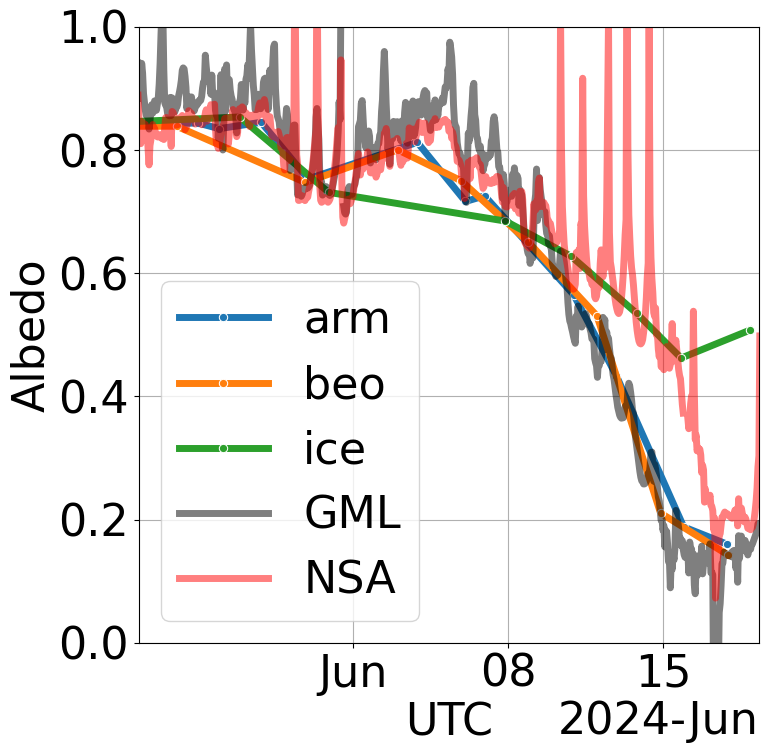

In [50]:
# Plot Albedo evolution

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# Line
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='albedo', hue='site', ax=ax,
            marker='o')
# hourly albedo rack
df_temp = df_gml.query("(incident_bestestimate_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)")
df_temp = df_temp['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
ax.plot('timestamp_akdt', 'albedo', data=df_temp, c='k', alpha=0.5)
# NSA albedo
df_temp = df_nsa['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
ax.plot('timestamp_akdt', 'albedo', data=df_temp, c='r', alpha=0.5)

ax.set_xlim([start_date, end_date])
ax.set_ylim(0, 1.0)
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('UTC')

ax.set_ylabel('Albedo')
ax.grid()

handles, labels = ax.get_legend_handles_labels()
labels[3] = 'GML'
labels[4] = 'NSA'
ax.legend(handles, labels)

f.savefig(os.path.join('..','figures','agu_albedo_2024.png'), bbox_inches='tight')

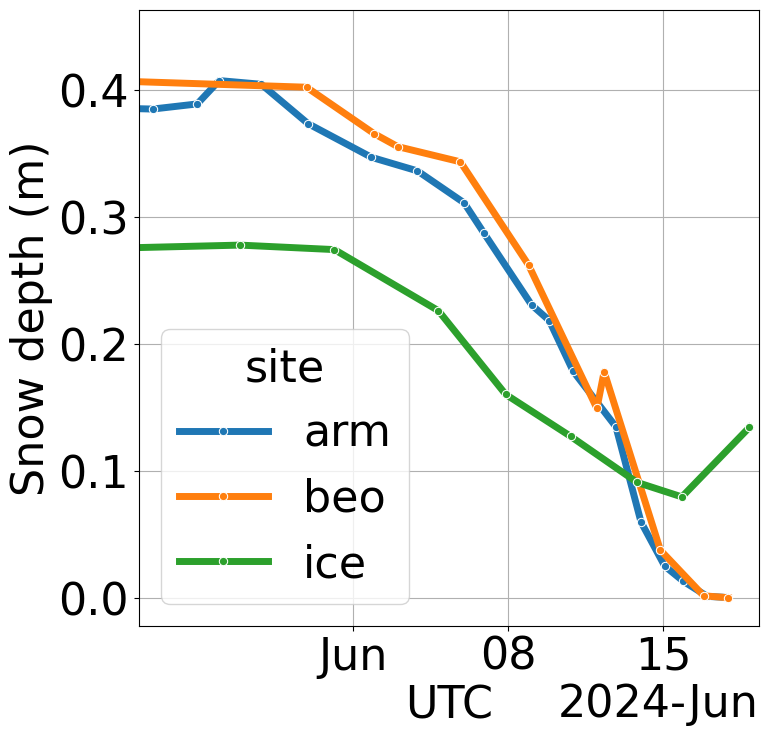

In [51]:
# Plot snow depth evolution

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# Line
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.query('position != -999.0')
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='snow_depth_m', hue='site', ax=ax,
            marker='o')

ax.set_xlim([start_date, end_date])
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('UTC')

ax.set_ylabel('Snow depth (m)')
ax.grid()

f.savefig(os.path.join('..','figures','agu_hs_2024.png'), bbox_inches='tight')

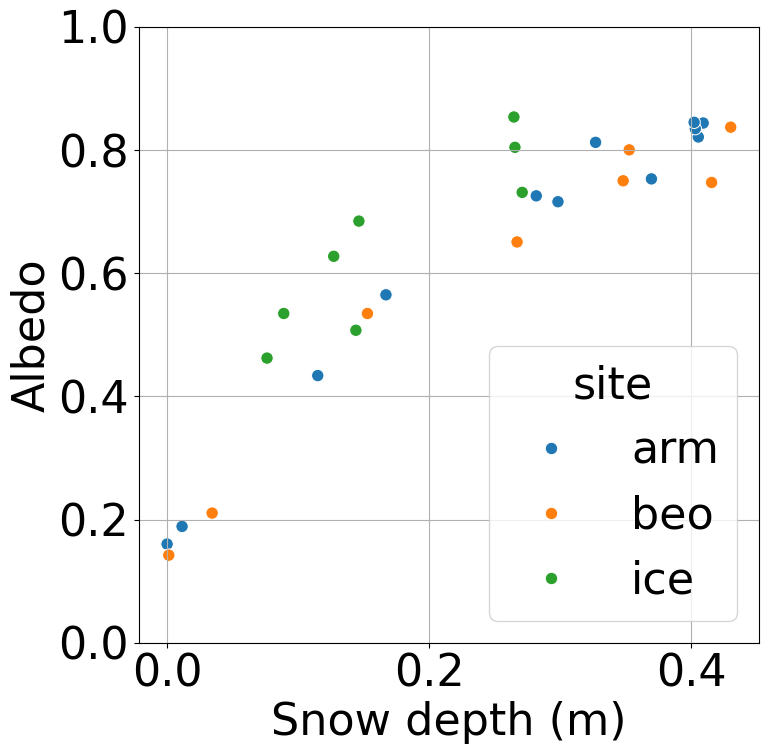

In [52]:
# Plot snow depth vs albedo

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# Line
df_temp = pd.merge(line_date_agg(df, 'albedo'),
                   line_date_agg(df, 'snow_depth_m'),
                   left_index=True, right_index=True,)
sns.scatterplot(x='snow_depth_m', y='albedo', hue='site', legend=True,
                s=80,
                data=df_temp.groupby(level=['site','date_akdt']).mean(), ax=ax)

ax.set_xlabel('Snow depth (m)')
ax.set_ylabel('Albedo')
ax.set_ylim([0, 1.0])
ax.grid()

f.savefig(os.path.join('..','figures','agu_hs_albedo_2024.png'), bbox_inches='tight')

In [44]:
# Plot Temperature, melt rate and albedo

# Create melt dataframe
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.groupby(level=['site', 'date_akdt']).mean().sort_index().reset_index()
df_temp2 = df_temp.copy()
df_temp2.index = df_temp2.index + 1
df_melt = pd.merge(df_temp2, df_temp, left_index=True, right_index=True, suffixes=('_start', '_end'))
df_melt = df_melt.loc[df_melt['site_start'] == df_melt['site_end']]
df_melt['site'] = df_melt['site_start']
df_melt = df_melt.drop(columns=['site_start', 'site_end'])
df_melt['snow_depth_m_delta'] = df_melt['snow_depth_m_end'] - df_melt['snow_depth_m_start']
df_melt['snow_melt_rate_m_per_day'] = -1*df_melt['snow_depth_m_delta'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))


In [45]:
df_nsa

,BestEstimate_down_short_hemisp,up_short_hemisp,down_long_hemisp,up_long_hemisp,Temp_Air,wind_speed,albedo
timestamp_utc,,,,,,,
2024-04-14 00:00:00+00:00,475.700409,386.747192,163.757797,247.827103,-16.100012,9.990,0.813006
2024-04-14 00:01:00+00:00,475.661591,387.132111,163.801895,247.749207,-16.100012,9.740,0.813881
2024-04-14 00:02:00+00:00,475.058105,386.395996,163.970001,247.734207,-16.100012,9.800,0.813366
2024-04-14 00:03:00+00:00,474.920807,386.888611,163.676804,247.689697,-16.100012,9.810,0.814638
2024-04-14 00:04:00+00:00,474.204987,385.918701,163.557098,247.580002,-16.100012,10.150,0.813823
...,...,...,...,...,...,...,...
2024-06-20 23:55:00+00:00,653.634338,118.401703,249.804199,360.975708,2.265008,4.423,0.181144
2024-06-20 23:56:00+00:00,653.222351,118.342201,249.830902,361.626099,2.458002,4.537,0.181167
2024-06-20 23:57:00+00:00,651.611145,118.209000,249.875397,361.089203,2.097986,5.052,0.181410


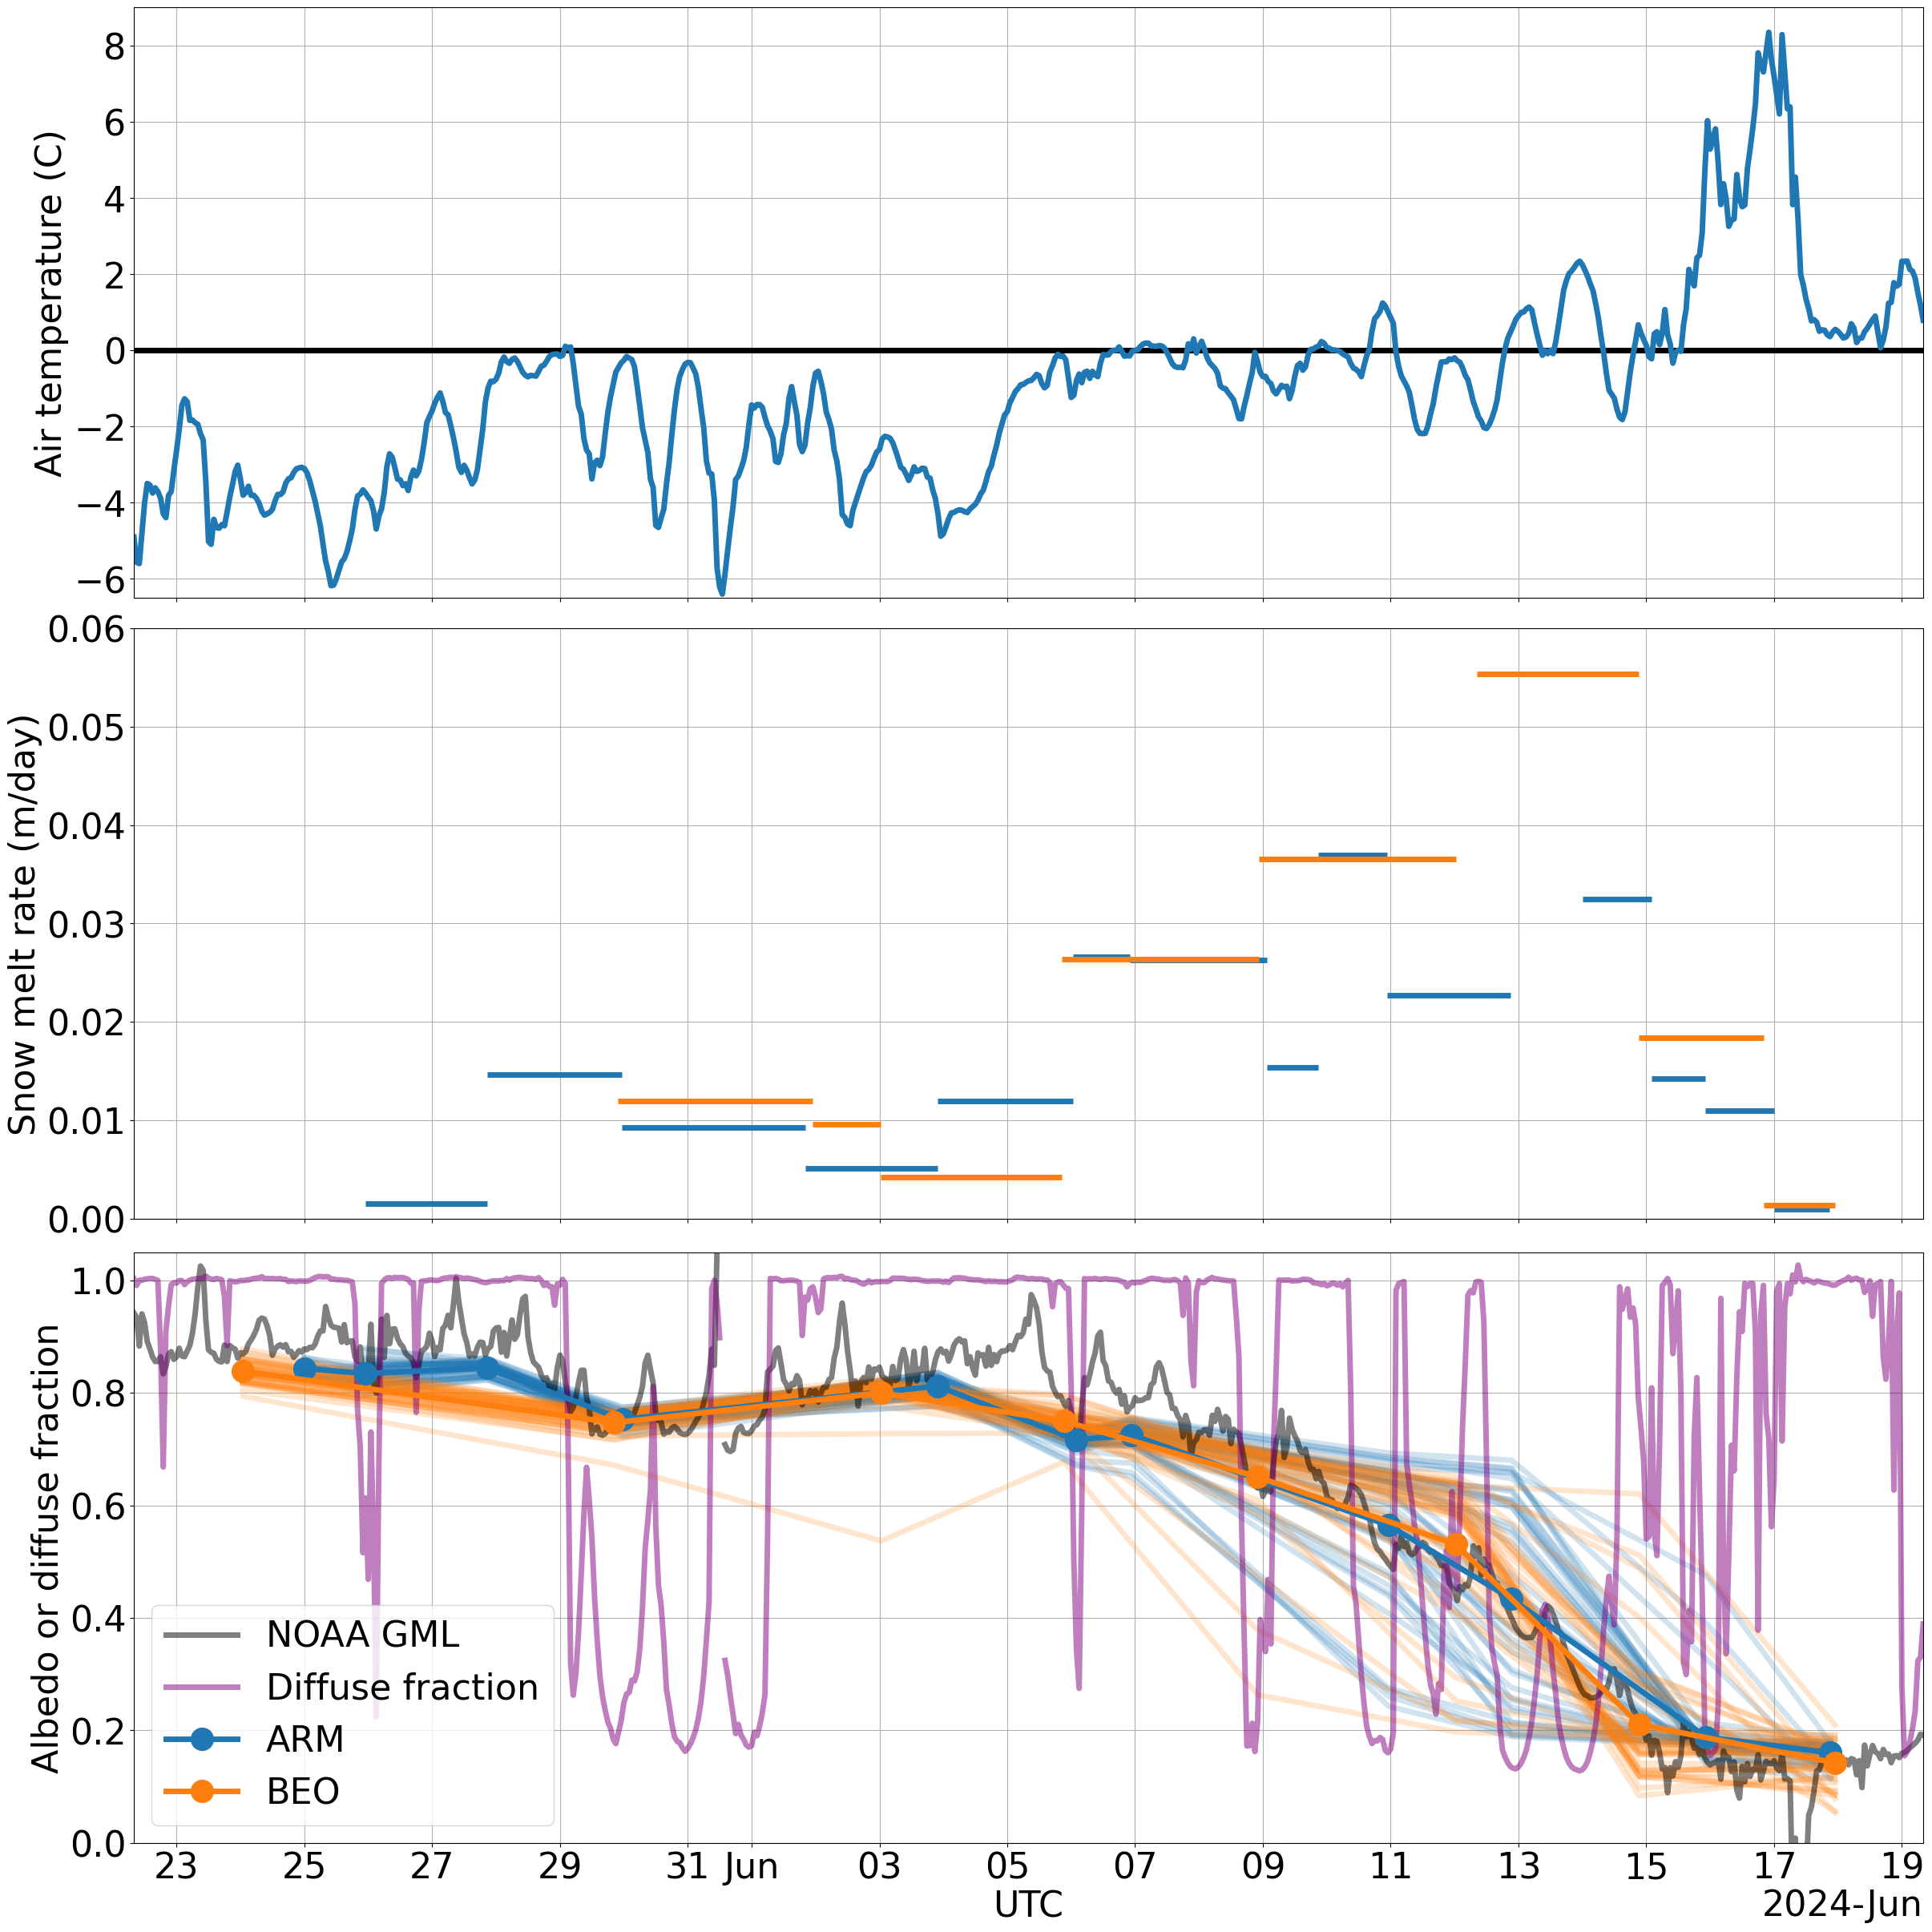

In [75]:

f, axs = plt.subplots(3, 1, sharex=True, figsize=(24, 24), constrained_layout=True)

# Temperature
df_temp = df_nsa['Temp_Air'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.loc[slice(start_date, end_date)]
df_temp = df_temp.reset_index()
axs[0].axhline(y=0, c='k')
axs[0].plot('timestamp_akdt', 'Temp_Air', data=df_temp, c='tab:blue')

axs[0].set_ylabel('Air temperature (C)')
axs[0].set_ylim([-6.5, 9])
axs[0].grid()

# Melt Rate
df_temp = df_melt.loc[(df_melt.meantime_akdt_start>=start_date) & (df_melt.meantime_akdt_end<=end_date)]

site = 'arm'
color = 'tab:blue'
axs[1].hlines('snow_melt_rate_m_per_day', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site, color=color)
site = 'beo'
color = 'tab:orange'
axs[1].hlines('snow_melt_rate_m_per_day', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site, color=color)
axs[1].grid()
axs[1].set_ylim([0, 0.06])
axs[1].set_ylabel('Snow melt rate (m/day)')

# Albedo
df_albedo = line_date_agg(df, 'albedo')
df_albedo = df_albedo.query('position != -999.0')
df_albedo = df_albedo.query('meantime_akdt >= @start_date')
# Plot albedo
df_alb_wide = df_albedo.xs('arm', level='site').reset_index().drop(columns='date_akdt').pivot(columns='position', index='meantime_akdt')
axs[2].plot(df_alb_wide, color='tab:blue', alpha=0.2)
df_alb_wide = df_albedo.xs('beo', level='site').reset_index().drop(columns='date_akdt').pivot(columns='position', index='meantime_akdt')
axs[2].plot(df_alb_wide, color='tab:orange', alpha=0.2)
df_temp = df_gml.query("(incident_bestestimate_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)")
df_temp = df_temp[['albedo', 'diffuse_frac']].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.loc[slice(start_date, end_date)]
df_temp = df_temp.reset_index()
axs[2].plot('timestamp_akdt', 'albedo', data=df_temp, c='k', alpha=0.5, label='NOAA GML')
axs[2].plot('timestamp_akdt', 'diffuse_frac', data=df_temp, c='purple', alpha=0.5, label='Diffuse fraction')
axs[2].plot('meantime_akdt', 'albedo', data=df_albedo.xs('arm', level='site').groupby('date_akdt').mean(),
            color='tab:blue', marker='o', label='ARM', markersize=20)
axs[2].plot('meantime_akdt', 'albedo', data=df_albedo.xs('beo', level='site').groupby('date_akdt').mean(),
            color='tab:orange', marker='o', label='BEO', markersize=20)
axs[2].legend(loc='lower left')

axs[2].set_ylabel('Albedo or diffuse fraction')
axs[2].set_ylim([0, 1.05])
axs[2].grid()

axs[2].set_xlim([start_date, end_date])
locator = mdates.AutoDateLocator(minticks=9, maxticks=21)
formatter = mdates.ConciseDateFormatter(locator)
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)
axs[2].set_xlabel('UTC')

f.savefig(os.path.join('..','figures','agu_temp_melt_albedo_2024.png'), bbox_inches='tight')

In [66]:
# Export nsa data
df_nsa.resample('1h').mean().to_csv(os.path.join('..','export','nsa_hourly.csv'))

In [70]:
# Export snow depth
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
df_temp.to_csv(os.path.join('..','export','mean_snow_depth.csv'))

In [71]:
# export albedo
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
df_temp.to_csv(os.path.join('..','export','mean_albedo.csv'))